In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import ArrowStyle
from pathlib import Path

# Insert code
import sys
sys.path.insert(0, '../..')

import corneto as cnt
cnt.__version__

'0.9.0-alpha.0'

## Basic data manipulation

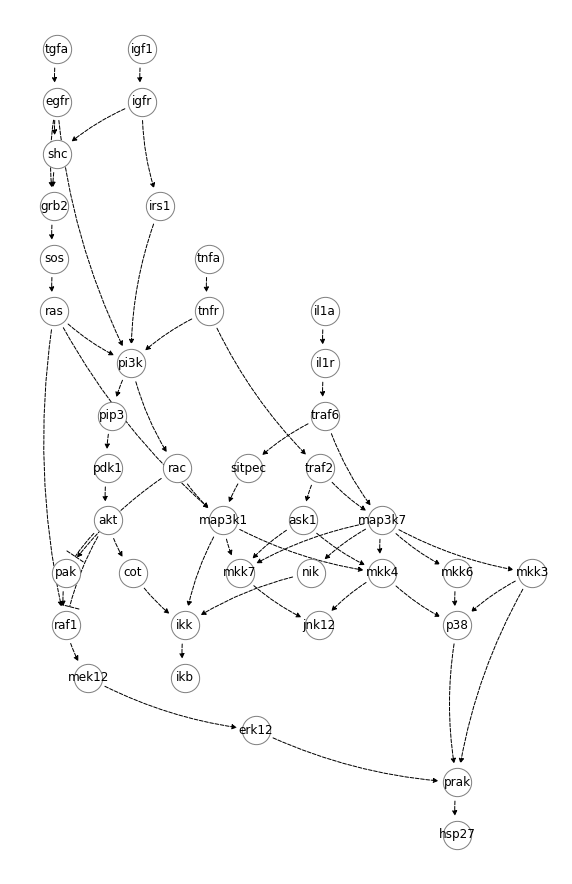

In [2]:
rn = cnt.ReNet.from_sif('../../tests/sif/PKN-LiverDREAM.sif')
rn.plot(figsize=(10, 16));

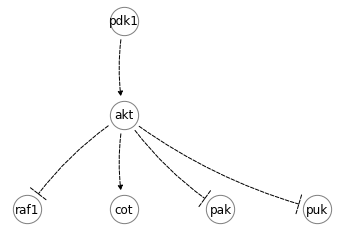

In [3]:
n0 = rn.select(['akt'])
n0.add_reaction('r1', {'akt': -1, 'puk': 1}, value=-1, inplace=False).plot();

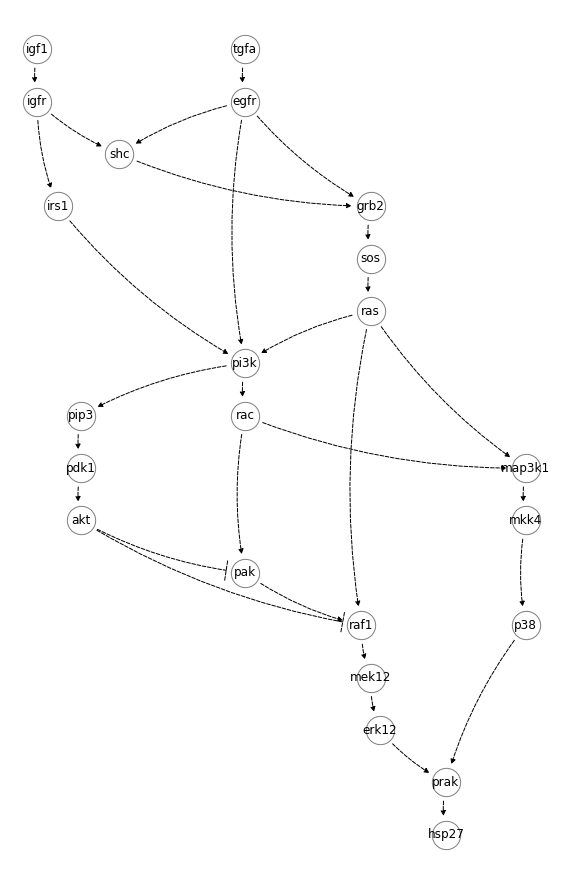

In [4]:
rn.prune(['tgfa', 'igf1'], ['hsp27']).plot(figsize=(10, 16));

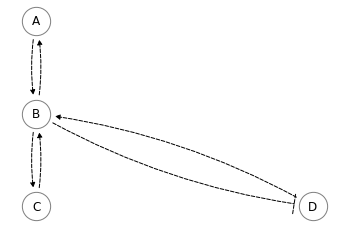

In [5]:
# Create a biochemical network from a dataframe
df_toy = pd.DataFrame({'source':      ['A', 'B', 'B', 'C', 'B', 'D'], 
                       'interaction': [ 1,   1,   1,   1,  -1,   1 ], 
                       'target':      ['B', 'A', 'C', 'B', 'D', 'B']})
rows = [(r.source, r.interaction, r.target) for (i, r) in df_toy.iterrows()]
cnt.ReNet.from_sif(rows).plot();

## CARNIVAL single/multi-condition

In [7]:
rn = cnt.ReNet.from_sif(rows)
rn

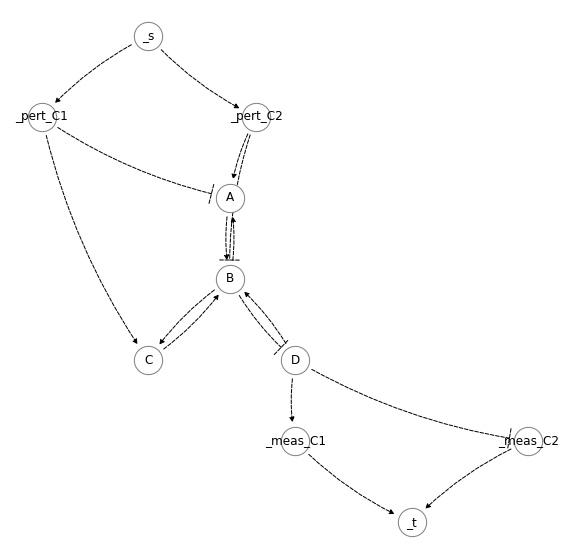

In [8]:
from corneto.methods.carnival import carnival_renet, carnival

data = {
    'C1': {
        'A': ('P', -5.1),
        'C': ('P', 1.2),
        'D': ('M', 0.5)
    },
    'C2': {
        'A': ('P', 1.1),
        'B': ('P', -0.5),
        'D': ('M', -1.1)
    }
}

# Transform the original network into a carnival network
rne = carnival_renet(rn, data)
rne.plot(figsize=(10, 10));

In [9]:
m = carnival(rne, data, l0_penalty_reaction=1e-4)

In [10]:
# Show declared vars in carnival
m._index

{'_flow_rxn': Variable((18,)),
 '_is_flow_rxn_positive': Variable((18,), boolean=True),
 'species_activated_C1': Variable((10,), boolean=True),
 'species_inhibited_C1': Variable((10,), boolean=True),
 'reaction_activates_C1': Variable((18,), boolean=True),
 'reaction_inhibits_C1': Variable((18,), boolean=True),
 'dag_layer_position_C1': Variable((10,)),
 'species_activated_C2': Variable((10,), boolean=True),
 'species_inhibited_C2': Variable((10,), boolean=True),
 'reaction_activates_C2': Variable((18,), boolean=True),
 'reaction_inhibits_C2': Variable((18,), boolean=True),
 'dag_layer_position_C2': Variable((10,))}

In [11]:
# Constraints of carnival
m._constraints

[Equality(Expression(AFFINE, UNKNOWN, (10,)), Constant(CONSTANT, ZERO, ())),
 Inequality(Expression(AFFINE, NONNEGATIVE, (18,))),
 Inequality(Variable((18,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, ()), Constant(CONSTANT, NONNEGATIVE, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, (1,)), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, NONNEGATIVE, (1,)), Constant(CONSTANT, ZERO, ())),
 Inequality(Expression(AFFINE, NONNEGATIVE, (18,))),
 Inequality(Expression(AFFINE, NONNEGATIVE, (10,))),
 Inequality(Expression(AFFINE, NONNEGATIVE, (16,))),
 Inequality(Expression(AFFINE, NONNEGATIVE, (16,))),
 Inequality(Expression(AFFINE, UNKNOWN, (16,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (10,))),
 Inequality

In [12]:
m.solve(solver='cbc', verbosity=1).value

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 10 11:32:16 AM: Your problem has 168 variables, 57 constraints, and 0 parameters.
(CVXPY) Aug 10 11:32:16 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 10 11:32:16 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 10 11:32:16 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 10 11:32:16 AM: Compiling problem (target solver=CBC).
(CVXPY) Aug 10 11:32:16 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

1.00000015

In [13]:
for i, c in enumerate(data.keys()):
    print(c, "loss:", m._objectives[i].value)

C1 loss: [0.]
C2 loss: [1.]


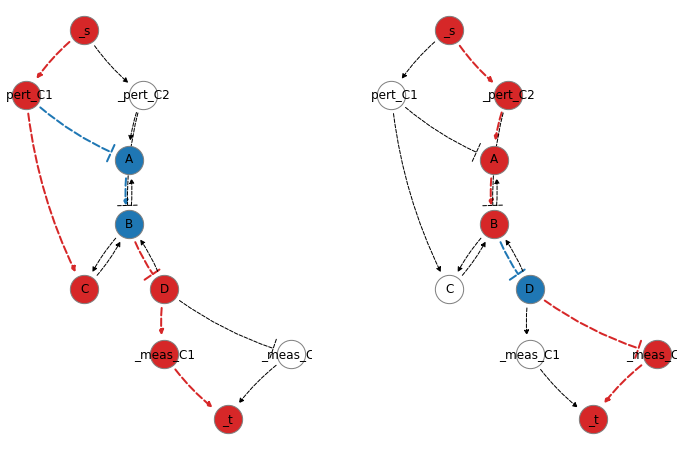

In [14]:
from corneto.methods.carnival import nx_style
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
rne.plot(custom_style=nx_style(rne, m, condition='C1'), ax=ax[0]);
rne.plot(custom_style=nx_style(rne, m, condition='C2'), ax=ax[1]);